In [2]:
from renewableopt.battery.data_import import import_datafile, DATA_DIR


# Analytic Observation Noise computation

In this notebook, we perform an analytic analysis of the noise, based on measurement precision specs of the battery tester.
A simple computation shows that the error in the capacity measurement is related to current measurement error by the following formula:

$
|\delta c| \leq \delta I (t_N - t_0) + 2 \delta t \sum_{i=0}^{N-1} I_i
$

where $\delta c$ error between measured and true capacity, $\delta I$ is the error in measurement, and $\delta t$ is the error in the timestamp. We assume $\delta I$ and $\delta t$ are zero-mean Gaussian distributed random variables. We assume the provided current measurement precision of $\delta I_{max}=$2.5 mA represents high probability bounds on the error $\delta I$. That is,

$
p(|\delta I| < \delta I_{max}) >= 0.997
$

Thus, $\delta I \sim \mathcal{N}(0, \sigma_I)$, where $3\sigma_I$ = $\delta I_{max}$

To determine $t_N$, $t_0$ and $I_i$, we look at the current curve during capacity measurement of a representative sample

In [3]:
c = import_datafile(DATA_DIR / "Stage_1" / "TP_z05_01" / "TP_z05_01_01_ET_T10.csv")

In [4]:
charge = c[c.step_type == 21].copy()
charge.run_time -= charge.run_time.iloc[0]

In [5]:
c_rate0 = max(charge['c_cur']) * 2

In [6]:
# Sum of current over measurement (in A)
sum(charge['c_cur'])

1734.613307606931

In [7]:
# Times current resolution (As) -> relatively very small value in Ah
sum(charge['c_cur']) * 1e-6

0.001734613307606931

In [8]:
c_rate0 / 20

0.24500258832641403

In [9]:
t_total = max(charge.run_time)

In [221]:
# Total time (T_n - t_0) in hours.
t_total / 3600

2.48172311111111

In [224]:
charge.run_time[:20]

6315      0.0000
6316      0.2390
6317      0.2412
6318     10.2390
6319     20.2390
6320     30.2390
6321     40.2390
6322     50.2390
6323     60.2390
6324     70.2390
6325     80.2390
6326     90.2390
6327    100.2390
6328    110.2390
6329    120.2390
6330    130.2390
6331    140.2390
6332    150.2390
6333    160.2390
6334    170.2390
Name: run_time, dtype: float64

In [225]:
np.mean(np.diff(charge.run_time))

9.937934593993322

In [226]:
dt = 10

In [227]:
t_total

8934.203199999996

In [229]:
(2.5 / 3)**2 * t_total / 3600 * dt / 3600

0.004787274519890259

In [11]:
# Sigma_c in mAh
t_total / 3600 * 2.5 / 3

2.068102592592592

<Axes: xlabel='run_time'>

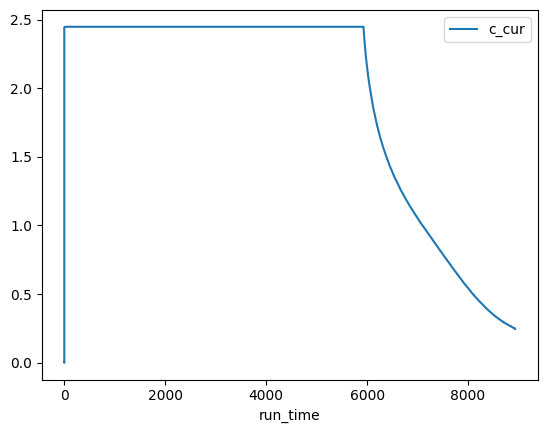

In [12]:
charge.plot("run_time", "c_cur")

# Validating against experimental data

To assess the experimental observation error, we compare the measured capacity in instances where the measured capacity should be constant. At each checkup, the capacity is measured twice: by integrating the current first, during a full charge, and second, during a full discharge. 

The difference between the current measurements is gaussian with zero mean and variance $2\sigma_c^2$ [Bertsekas p 216]. Define $\delta c ~ \mathcal{N}(0, 2\sigma_c^2)$. We consider the fact the the measurement noise may sensitive to the temperature of the cell during the checkup.

Let $\delta c_i(T)$ be the $i$th measurement of $\delta c$ at temperature $T$, and take the sample mean and sample variance to be:
$\underline{\sigma_{\delta c}^2}$.

In [13]:
from renewableopt.battery.data_import import DATA_DIR
from renewableopt.battery.feature_extraction import CapacityData

import pandas as pd

c = CapacityData.load(DATA_DIR / "aging.npz")

exp = pd.read_csv(DATA_DIR / "experiments_meta.csv")

# 

In [14]:
import numpy as np

In [159]:
help(np.nanmean)

Help on function nanmean in module numpy:

nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)
    Compute the arithmetic mean along the specified axis, ignoring NaNs.
    
    Returns the average of the array elements.  The average is taken over
    the flattened array by default, otherwise over the specified axis.
    `float64` intermediate and return values are used for integer inputs.
    
    For all-NaN slices, NaN is returned and a `RuntimeWarning` is raised.
    
    .. versionadded:: 1.8.0
    
    Parameters
    ----------
    a : array_like
        Array containing numbers whose mean is desired. If `a` is not an
        array, a conversion is attempted.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the means are computed. The default is to compute
        the mean of the flattened array.
    dtype : data-type, optional
        Type to use in computing the mean.  For integer inputs, the default
        is `fl

In [15]:
def row_from_uid(uid, exp):
    serial = uid[:9]
    stage = int(uid[-1])
    row = exp[
        (exp['serial'] == serial) &
        (exp['stage'] == stage)]
    if len(row) == 0:
        raise ValueError(f"UID {uid} not found")
    elif len(row) > 1:
        raise ValueError(f"Multiple UIDs found!")
    return row.iloc[0]

In [16]:
PREPROCESS_DTYPE = np.dtype([
    ("uid", "U11"),  # unique identifier of cell
    ("T", float),  # Ambient temperature during cycling
    ("T_m", float),  # Temperature during measurement
    ("delta", float),  # Depth of discharge
    ("Q", float),  # Max SoC
    ("gamma_ch", float),  # Charge rate
    ("gamma_dch", float),  # discharge rate
    ("k", float),  # Number of equivalent full cycles
    ("c_ch", float),  # Capacity measured during charge
    ("c_dch", float)  # Capacity measured during discharge
])

def preprocess(c: CapacityData, exp: pd.DataFrame):
    uids = sorted(list(c.keys()))
    # Filter out cell where the data was missing or corrupted.
    uids = [uid for uid in uids if c[uid] is not None]

    X = []  # Features to fit, tuples of (T_a, delta, Q, gamma+, gamma-, n_F)
    
    for uid in uids:
        row = row_from_uid(uid, exp)
        T_a = row["amb_temp_tp"]
        delta = row["dod_tp"]
        Q = row["soc_max_tp"]
        gamma_ch = row["c_ch_tp"]
        gamma_dch = row["c_dch_tp"]

        checkups = list(c[uid].iter_both())
        N = len(checkups)
        for i, (cap_ch, cap_dch, n_f) in enumerate(checkups):
            # T_m = Temperature at which capacity is measured
            if i == 0 or i == N - 3:
                T_m = 10
            elif i == 1 or i == N - 2:
                T_m = 23
            elif i == 2 or i == N - 1:
                T_m = 45
            else:
                T_m = T_a
                
            # if np.any(np.isnan(x_i)) or np.isnan(cap):
            #     continue
            x_i = (uid, T_a, T_m, delta, Q, gamma_ch, gamma_dch, n_f, cap_ch, cap_dch)
            X.append(x_i)
    return np.array(X, dtype=PREPROCESS_DTYPE)
    


In [17]:
X = preprocess(c, exp)

In [18]:
print("num NaN per column")
for column in X.dtype.names:
    if X[column].dtype == float:
        print(column, np.sum(np.isnan(X[column])))

num NaN per column
T 0
T_m 0
delta 0
Q 0
gamma_ch 0
gamma_dch 0
k 16
c_ch 0
c_dch 0


In [19]:
np.unique(X["T"])

array([23., 35., 45.])

In [20]:
np.unique(X["T_m"])

array([10., 23., 35., 45.])

In [21]:
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import kurtosis

In [25]:
help(np.std)

Help on function std in module numpy:

std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)
    Compute the standard deviation along the specified axis.
    
    Returns the standard deviation, a measure of the spread of a distribution,
    of the array elements. The standard deviation is computed for the
    flattened array by default, otherwise over the specified axis.
    
    Parameters
    ----------
    a : array_like
        Calculate the standard deviation of these values.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the standard deviation is computed. The
        default is to compute the standard deviation of the flattened array.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, a standard deviation is performed over
        multiple axes, instead of a single axis or all the axes as before.
    dtype : dtype, optional
        Type to use in computing the standard deviation. 

In [42]:
from scipy.stats import kurtosis

In [165]:
scipy.norm

NameError: name 'scipy' is not defined

In [170]:
from scipy.stats import norm

In [168]:
scipy.stats.norm

In [173]:
norm.pdf(0, 1)

0.24197072451914337

In [177]:
norm.pdf(0, loc=0, scale=10)

0.03989422804014327

In [174]:
help(norm.pdf)

Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Probability density function at x of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    pdf : ndarray
        Probability density function evaluated at x



# 

In [218]:
COLUMN_NAMES = ["mean", "std", "kurtosis", "rmse_mean", "exp_error_mean", "rmse_var", "exp_error_var"]
STAT_DTYPE = np.dtype([
    ("N", int),
    *[(name, float) for name in 
      COLUMN_NAMES]
])
class Stats:
    def __init__(self, x, exp_mean=0, exp_std=6.2):
        self.N = len(x)
        self.mean = np.mean(x)
        self.std = np.std(x, ddof=1)
        self.kurtosis = kurtosis(x)

        self.rmse_mean = np.sqrt((self.mean - exp_mean)**2)
        self.exp_error_mean = exp_std / np.sqrt(self.N)
        self.rmse_var = np.abs(self.std**2 - exp_std**2)
        self.exp_error_var = np.sqrt(2 * exp_std**4 / (self.N - 1))

    def array(self):
        return np.rec.array(
            tuple([getattr(self, name) for name in STAT_DTYPE.names]),
            dtype=STAT_DTYPE)
        
        
class NoiseAnalysis:
    def __init__(self, X, T_m):
        self.X = X
        self.T_m = T_m
        
        self.delta_c = X["c_ch"] - X["c_dch"]

        self.stats = Stats(1000 * self.delta_c)

        mu, sigma = self.stats.mean / 1000, self.stats.std / 1000
        self.outliers = np.logical_or(
            self.delta_c < mu - 3 * sigma,
            self.delta_c > mu + 3 * sigma
        )
        
        self.n_outliers = np.sum(self.outliers)
        self.delta_c_clean = self.delta_c[~self.outliers]
        self.stats_clean = Stats(1000 * self.delta_c_clean)

    def plot(self, outliers=True):
        
        dc = self.delta_c_clean if outliers else self.delta_c
        fig = plt.figure()
        plt.hist(1000 * dc, density=True, log=True)
        plt.title(f"Difference between Charge and Discharge Measurements (T_m = {self.T_m})")
        plt.xlabel("Charge measurement difference (mAh)")
        plt.ylabel("Probability Density")

        # std = 6.2
        # plt.axvline(x= -2 * std, c='r')
        # plt.axvline(x=2 * std, c='r', label="Analytical noise")
        x = np.linspace(-30, 30)
        # exp_count = len(dc) * norm.pdf(x, 0, 6.2)
        exp_count = norm.pdf(x, 0, 6.2)
        plt.plot(x, exp_count, c='r')
        # filt = exp_count > 1
        # plt.plot(x[filt], exp_count[filt], c='r')
        # plt.xlim([-30, 30])
        # print("x")
        # print(x)
        # print("log_p")
        # print(log_p)
        # if outliers:
        #     plt.title(f"delta c histogram w/ outliers (T_m = {self.T_m}")
        # else
            
        # plt.figure()
        # plt.hist(self.delta_c_clean)
        # plt.title(f"delta c histogram w/o outliers (T_m = {self.T_m}")
        return fig




noise_stats = [NoiseAnalysis(X[X["T_m"] == T_m], T_m)
               for T_m in np.unique(X["T_m"])]

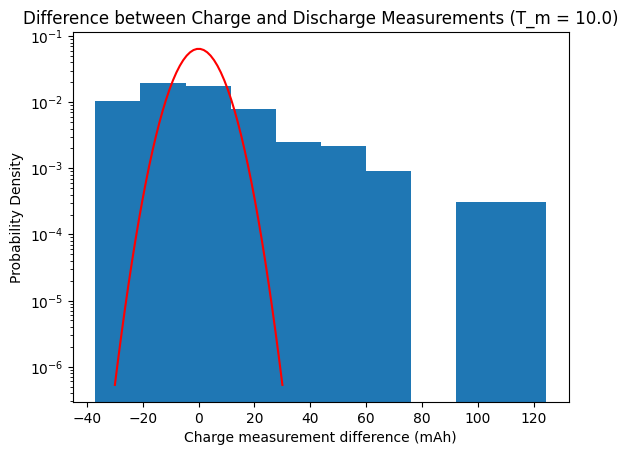

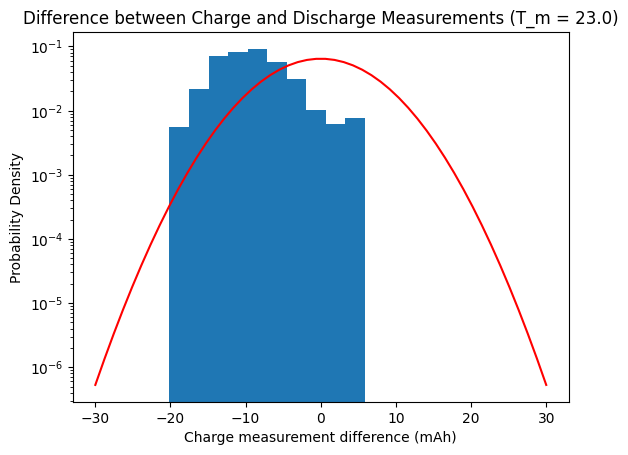

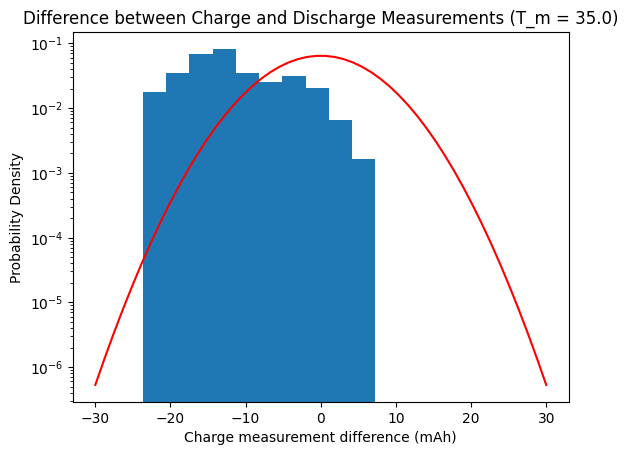

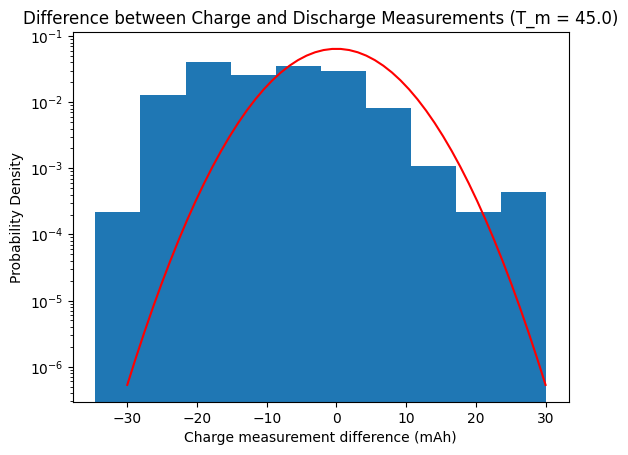

In [219]:
figs = [stats.plot() for stats in noise_stats]

In [214]:
from pathlib import Path

In [215]:
image_dir = Path("/home/sean/code/study-hard/stochastic-estimation/tex/project/draft/Images")

In [220]:
for i, fig in enumerate(figs):
    fig.savefig(image_dir / f"measurement_error_{i}.png")

In [132]:
from tabulate import tabulate

In [154]:
LABEL_MAP = {
    "T_m": "T_m (°C)",
    "mean": "Mean (mA)",
    "std": "std (mA)",
    "rmse_mean": "RMSE mean (mA)",
    "exp_error_mean": "Exp[RMSE mean] (mA)",
    "rmse_var": "RMSE var (mA^2)",
    "exp_error_var": "Exp[RMSE var] (mA^2)",
}

In [156]:
def format(noise_stats, outliers=False):
    if outliers:
        all_stats = np.r_[[n.stats_clean.array() for n in noise_stats]]
        n_outliers = [n.n_outliers for n in noise_stats]
    else:
        all_stats = np.r_[[n.stats.array() for n in noise_stats]]
    all_stats_dict = {"T_m (°C)": [n.T_m for n in noise_stats]}
    for name in all_stats.dtype.names:
        all_stats_dict[name] = all_stats[name]

    if outliers:
        order = ["T_m (°C)", "N"] + COLUMN_NAMES
        # order = ["T_m (°C)", "N", "# outliers"] + COLUMN_NAMES
        # all_stats_dict["# outliers"] = n_outliers
    else:
        order = ["T_m (°C)", "N"] + COLUMN_NAMES
        
    # for k in list(all_stats_dict.keys()):
    #     if k in ["T_m (°C)", "N", "kurtosis", "# outliers"]:
    #         continue
    #     new_k = f"{k} (mA)"
    #     all_stats_dict[new_k] = all_stats_dict.pop(k)
    #     order[order.index(k)] = new_k
    
    return {LABEL_MAP.get(k, k): all_stats_dict[k] for k in order}

In [157]:

print(tabulate(format(noise_stats, outliers=True), headers="keys"))

  T_m (°C)    N    Mean (mA)    std (mA)    kurtosis    RMSE mean (mA)    Exp[RMSE mean] (mA)    RMSE var (mA^2)    Exp[RMSE var] (mA^2)
----------  ---  -----------  ----------  ----------  ----------------  ---------------------  -----------------  ----------------------
        10  201    -0.415802    23.3755     5.59376           0.415802               0.437314         507.976                    3.844
        23  560    -9.10148      4.51506    0.571727          9.10148                0.261998          18.0542                   2.29928
        35  394   -11.6979       6.20956   -0.350447         11.6979                 0.312351           0.118626                 2.74222
        45  709    -9.32776      9.40397   -0.235385          9.32776                0.232846          49.9946                   2.04306


In [25]:
print("Statistics for delta_c")
print("T_m  | N   | mean | std | var")
for s in noise_stats:
    print(f"{s.T_m} | {s.N} | {s.mean:.3f} | {s.std:.4f} | {s.std**2:.6f}")
    
print("Statistics for delta_c w/o outliers")
print("T_m  | N   | n_outliers | mean   | std    | var")
for s in noise_stats:
    print(f"{s.T_m} | {s.N} | {s.n_outliers}          | {s.mean:.3f} | {s.std:.4f} | {s.std**2:.6f}")

Statistics for delta_c
T_m  | N   | mean | std | var
10.0 | 202 | 0.007 | 0.1077 | 0.011593
23.0 | 565 | -0.009 | 0.0050 | 0.000025
35.0 | 396 | -0.012 | 0.0067 | 0.000044
45.0 | 711 | -0.010 | 0.0580 | 0.003359
Statistics for delta_c w/o outliers
T_m  | N   | n_outliers | mean   | std    | var
10.0 | 202 | 1          | 0.007 | 0.1077 | 0.011593
23.0 | 565 | 5          | -0.009 | 0.0050 | 0.000025
35.0 | 396 | 2          | -0.012 | 0.0067 | 0.000044
45.0 | 711 | 2          | -0.010 | 0.0580 | 0.003359


In [27]:
n = noise_stats[0]

In [41]:
outlier_rows = []
for n in noise_stats:
    outlier_rows.extend(n.X[n.outliers])

In [44]:
len(outlier_rows)

10

In [46]:
for i, row in enumerate(outlier_rows):
    print(f"Outlier {i}")
    print(row)
    print(np.argwhere(X == row)[0, 0])
    print(X[X['uid'] == row['uid']])

Outlier 0
('TP_z25_01_1', 45., 10., 0.15, 0.6, 0.9, 1.9, 4496.72900391, 5.37497091, 3.8775301)
1831
[('TP_z25_01_1', 45., 10., 0.15, 0.6, 0.9, 1.9,    0.        , 4.79989481, 4.83689833)
 ('TP_z25_01_1', 45., 23., 0.15, 0.6, 0.9, 1.9,    0.        , 4.87218809, 4.88796568)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,    0.        , 3.1701932 , 4.58019972)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,   79.13929749, 4.81362724, 4.83629704)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,  183.49508667, 4.69922781, 4.68336487)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,  286.00119019, 4.64841366, 4.67364883)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,  491.25390625, 4.56476831, 4.58315849)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,  696.32110596, 4.51090717, 4.52136278)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9,  901.42687988, 4.46775436, 4.47189426)
 ('TP_z25_01_1', 45., 45., 0.15, 0.6, 0.9, 1.9, 1311.40026855, 4.38356733, 4.38655758)
 ('TP_z25_01_1', 45., 45., 0.1

In [48]:
obvious_outliers = np.array([
    ("TP_z25_01_1", 10, 4497),
    ("TP_z25_01_1", 45, 0),
    ("TP_z25_01_1", 45, 3677),
])



In [51]:
help(np.isclose)

Help on function isclose in module numpy:

isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)
    Returns a boolean array where two arrays are element-wise equal within a
    tolerance.
    
    The tolerance values are positive, typically very small numbers.  The
    relative difference (`rtol` * abs(`b`)) and the absolute difference
    `atol` are added together to compare against the absolute difference
    between `a` and `b`.
    
    .. warning:: The default `atol` is not appropriate for comparing numbers
                 that are much smaller than one (see Notes).
    
    Parameters
    ----------
    a, b : array_like
        Input arrays to compare.
    rtol : float
        The relative tolerance parameter (see Notes).
    atol : float
        The absolute tolerance parameter (see Notes).
    equal_nan : bool
        Whether to compare NaN's as equal.  If True, NaN's in `a` will be
        considered equal to NaN's in `b` in the output array.
    
    Returns
    -------


In [65]:
outlier_filter = np.ones(X.shape, dtype=bool)
for uid, T_m, n_F in obvious_outliers:
    print(n_F)
    match = (
        X['uid'] == uid) & (
        np.isclose(X["T_m"], float(T_m))) & (
        np.isclose(X['k'], float(n_F), atol=1))
    print(np.sum(match))
    outlier_filter &= ~match
                                                                        

4497
1
0
1
3677
1


In [59]:
np.sum(np.isclose(X["k"], 4497, atol=1))

3

In [66]:
X.shape

(1874,)

In [67]:
np.sum(outlier_filter)

1871

In [68]:
X_filt = X[outlier_filter]

In [69]:
help(np.savez)

Help on function savez in module numpy:

savez(file, *args, **kwds)
    Save several arrays into a single file in uncompressed ``.npz`` format.
    
    Provide arrays as keyword arguments to store them under the
    corresponding name in the output file: ``savez(fn, x=x, y=y)``.
    
    If arrays are specified as positional arguments, i.e., ``savez(fn,
    x, y)``, their names will be `arr_0`, `arr_1`, etc.
    
    Parameters
    ----------
    file : str or file
        Either the filename (string) or an open file (file-like object)
        where the data will be saved. If file is a string or a Path, the
        ``.npz`` extension will be appended to the filename if it is not
        already there.
    args : Arguments, optional
        Arrays to save to the file. Please use keyword arguments (see
        `kwds` below) to assign names to arrays.  Arrays specified as
        args will be named "arr_0", "arr_1", and so on.
    kwds : Keyword arguments, optional
        Arrays to save

In [70]:
np.savez(DATA_DIR / "cleaned_data.npz", x=X_filt)